本 NoteBook 是 Kaggle M5 时序预测比赛的 Baseline，主要使用机器学习的建模方式进行时序的建模和预测。

- **BaseLine步骤**：    
                        1. 数据分析 EDA
                        2. 特征工程
                        3. 模型训练
                        4. 线下验证

In [2]:
# import libs

## official libs
import pprint as pp

#import display

## compute libs
import pandas as pd
import numpy as np

## vis libs
import pandas.plotting as pds
import matplotlib.pyplot as plt
import seaborn as sns

## display
import IPython.display as dis
%matplotlib inline

In [2]:
# compress

'''filelist = ['dataset/calendar.csv', 'dataset/sales_train_validation.csv', 'dataset/sample_submission.csv', 'dataset/sell_prices.csv']

for file in filelist:
    df = pd.read_csv(file)
    print('checking: ', file)
    print(df.shape)
    df.to_pickle(file+'.pk.xz', compression='xz')
    dfc = pd.read_pickle(file+'.pk.xz', compression='xz')
    print(dfc.shape)
# 压缩数据'''

checking:  dataset/calendar.csv
(1969, 14)
(1969, 14)
checking:  dataset/sales_train_validation.csv
(30490, 1919)
(30490, 1919)
checking:  dataset/sample_submission.csv
(60980, 29)
(60980, 29)
checking:  dataset/sell_prices.csv
(6841121, 4)
(6841121, 4)


## 一、数据分析

为了节约时间，我们直接对我们后面建模有用的结果进行分析，关于数据的详细分析可以参考 [EDA](https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda)

- 查看 sales 数据前几行
- 查看 sales 数据聚合结果趋势
- 查看 sales 数据标签分布

In [8]:
sale_data = pd.read_pickle('dataset/sales_train_validation.csv.pk.xz')
sale_data.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [9]:
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

In [12]:
day_data[:3]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


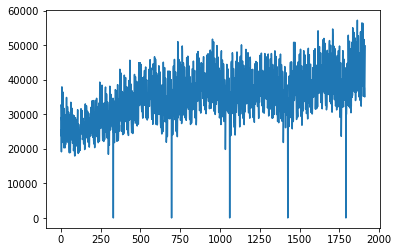

In [10]:
plt.plot(total_sum);

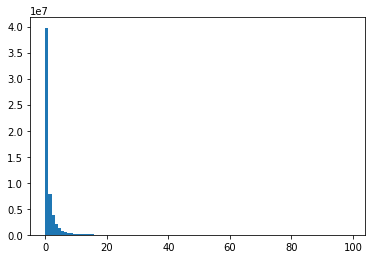

In [15]:
plt.hist(day_data[day_data<100].values.reshape(-1),bins=100);
# 使用query 调整

---
## 二、特征工程

选定机器学习的建模方案，核心思想是对时间序列抽取窗口特征。

<img src="机器学习建模.jpg" style="width:1100px;height:500px;float:center">



抽取窗口特征：

- 前7天
- 前28天
- 前7天均值
- 前28天均值

关联其他维度信息

- 日期
- 价格

In [3]:
import sys
import lightgbm as lgb
#conda install lightgbm
from datetime import datetime, timedelta

In [4]:
def create_train_data(train_start=750,test_start=1800,is_train=True):
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据
    #price_data = pd.read_pickle('./dataset/sell_prices.csv.pk.az',dtype=PRICE_DTYPES)
    #price_data = pd.read_pickle('dataset/sell_prices.csv.pk.xz')
    # 加载cal数据
    #cal_data = pd.read_pickle('./dataset/calendar.csv.pk.az',dtype=CAL_DTYPES)
    #cal_data = pd.read_pickle('dataset/calendar.csv.pk.xz')
    # 加载sale数据
    #sale_data = pd.read_csv('./dataset/sales_train_validation.csv.pk.az',dtype=SALE_DTYPES,usecols=catcols+numcols)
    #sale_data = pd.read_csv('dataset/sales_train_validation.csv.pk.xz')
    
    # 加载price数据
    price_data = pd.read_csv('./dataset/sell_prices.csv',dtype=PRICE_DTYPES)
    # 加载cal数据
    cal_data = pd.read_csv('./dataset/calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据
    sale_data = pd.read_csv('./dataset/sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)


    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    # 注意提交格式里有一部分为空
    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data


def create_feature(sale_data, is_train=True, day=None):
    # 可以在这里加入更多的特征抽取方法
    # 获取7天前的数据，28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 注意训练集和测试集特征生成要一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values  


    # 将获取7天前的数据，28天前的数据做移动平均
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    # 处理时间特征
    # 有的时间特征没有，通过datetime的方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [5]:
sale_data = create_train_data(train_start=350,is_train=True)
sale_data = create_feature(sale_data)

# 清洗数据，选择需要训练的数据
sale_data.dropna(inplace=True)
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]
X_train = sale_data[train_cols]
y_train = sale_data["sales"]

In [6]:
X_train.head(5)

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
869062,1,0,0,0,0,6,3,2012,24,3,...,3.97,0.0,0.0,0.000000,0.142857,0.214286,0.214286,10,1,8
869063,1,0,0,0,0,7,3,2012,0,0,...,3.97,0.0,1.0,0.000000,0.142857,0.178571,0.250000,10,1,9
869069,3,0,0,0,0,6,3,2012,24,3,...,4.34,3.0,2.0,1.857143,1.142857,1.392857,1.678571,10,1,8
869070,3,0,0,0,0,7,3,2012,0,0,...,4.34,1.0,0.0,2.000000,1.000000,1.392857,1.607143,10,1,9
869076,4,0,0,0,0,6,3,2012,24,3,...,2.98,0.0,0.0,0.000000,1.857143,0.750000,0.642857,10,1,8


In [7]:
y_train.head(5)

869062    0.0
869063    0.0
869069    1.0
869070    2.0
869076    0.0
Name: sales, dtype: float32

---

## 三、模型训练

选择 LGB 模型进行模型的训练。

[LGB安装](https://blog.csdn.net/u011433858/article/details/80402938)

- 损失函数的选择
- 预测时候的技巧

<img src="tweedie.png" style="width:300px;height:200px;float:center">

tweedie_variance_power 参数的选择 [1,2] 之间。

LGB 模型是 GBDT 模型的变种，无法突然训练集的上界。

In [8]:
def train_model(train_data,valid_data):
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        "nthread": 8,
        "tweedie_variance_power":1.1,
    'verbosity': 1,
    'num_iterations' : 1500,
    'num_leaves': 128,
    "min_data_in_leaf": 104,
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

    return m_lgb

In [9]:
def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4, 25) 
    # alphas = [1.035, 1.03, 1.025, 1.02]
    # alphas = [1.028, 1.023, 1.018]
    alphas = [1.035, 1.03, 1.025]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(is_train=False)

    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

        test_data_c = test_data.copy()
        cols = [f"F{i}" for i in range(1,29)]


        for i in range(0, 28):
            day = date + timedelta(days=i)
            print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]

            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

        # 改为提交数据的格式
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
        test_sub.fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols] *= weight
        else:
            sub[cols] += test_sub[cols]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()
    # 把大于28天后的validation替换成evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submissionV3.csv",index=False)

In [10]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_inds = np.random.choice(len(X_train), 10000)
valid_data = lgb.Dataset(X_train.iloc[valid_inds], label = y_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False) 

m_lgb = train_model(train_data,valid_data) 
predict_ensemble(train_cols,m_lgb)

C:\Users\mengf\miniconda3\envs\py38\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\mengf\miniconda3\envs\py38\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LightGBMError: bad allocation

---
## 四、线下验证

WRMSSE 的评估方法和 RMSE 很不一致，我们需要拆分出么一条时间序列的权重到底是多少，一方面能帮助我们做线下验证，另一方面可以帮助我们思考能否使用自定义的损失函数。

<img src="评估指标.jpg" style="width:500px;height:100px;float:center">


In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

# 转换数据类型，减少内存占用空间
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# 加载数据
data_pass = './m5-forecasting-accuracy/'

# sale数据
sales = pd.read_csv(data_pass+'sales_train_validation.csv')

# 日期数据
calendar = pd.read_csv(data_pass+'calendar.csv')
calendar = reduce_mem_usage(calendar)

# 价格数据
sell_prices = pd.read_csv(data_pass+'sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

# 计算价格
# 按照定义，只需要计算最近的 28 天售卖量（售卖数*价格），通过这个可以得到 weight
# 可以不是 1914
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# 从横表改为纵表
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# 和日期数据做关联
data = pd.merge(data, calendar, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# 和价格数据关联
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# 计算售卖量
data['sale_usd'] = data['sale'] * data['sell_price']

# 得到聚合矩阵
# 30490 -> 42840
# 需要聚合的维度明细计算出来
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id + sales.cat_id, sales.state_id + sales.dept_id,
                sales.store_id + sales.cat_id, sales.store_id + sales.dept_id, 
                sales.item_id, sales.state_id + sales.item_id, sales.id]


# 全部聚合为一个， 最高 level
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# 挨个计算其他 level 等级聚合
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# 得到聚合矩阵
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# 保存聚合矩阵
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_df.to_pickle('roll_mat_df.pkl')

# 释放内存
del dummies_df_list, roll_mat_df
gc.collect()


# 按照定义，计算每条时间序列 RMSSE 的权重:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    
    # 要计算的时间序列长度
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    # 得到聚合结果
    sales_train_val = roll_mat_csr * sales[d_name].values

    # 按照定义，前面连续为 0 的不参与计算
    start_no = np.argmax(sales_train_val>0, axis=1)
    
    # 这些连续为 0 的设置为 nan
    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914-drop_days),(roll_mat_csr.shape[0],1)))<1
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # 根据公式计算每条时间序列 rmsse的权重
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no-1)
    
    return weight1

S = get_s(drop_days=0)

# 根据定义计算 WRMSSE 的权重，这里指 w 
def get_w(sale_usd):
    """
    """
    # 得到最细维度的每条时间序列的权重
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # 通过聚合矩阵得到不同聚合下的权重
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)


W = get_w(data[['id','sale_usd']])

SW = W/np.sqrt(S)

sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

# 评分函数
# 得到聚合的结果
def rollup(v):
    '''
    '''
    return (v.T*roll_mat_csr.T).T


# 计算 WRMSSE 评估指标
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw *12)
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None]) *12 / s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))
        return score, score_matrix


# 加载前面预先计算好的各个权重
file_pass = './'
sw_df = pd.read_pickle(file_pass+'sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

roll_mat_df = pd.read_pickle(file_pass+'roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)

print(sw_df.loc[(11,slice(None))].sw)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
id
FOODS_1_001_CA_1_validation        1.153816e-05
FOODS_1_001_CA_2_validation        7.733063e-06
FOODS_1_001_CA_3_validation        4.491764e-06
FOODS_1_001_CA_4_validation        5.327781e-06
FOODS_1_001_TX_1_validation        3.212428e-07
FOODS_1_001_TX_2_validation        4.304805e-06
FOODS_1_001_TX_3_validation        7.321928e-06
FOODS_1_001_WI_1_validation        8.135162e-06
FOODS_1_001_WI_2_validation        5.394022e-06
FOODS_1_001_WI_3_validation        6.653099e-06
FOODS_1_002_CA_1_validation        2.847785e-05
FOODS_1_002_CA_2_validation        3.831573e-05
FOODS_1_002_CA_3_validation        3.425349e-05
FOODS_1_002_CA_4_validation        1.124738e-05
FOODS_1_002_TX_1_validation        7.017587e-06
FOODS_1_002_TX_2_validation        1.003577e-05
FOODS_1_002_TX_3_validation        2.929136e-05
FOODS_1_002_WI_1_validation        4.447014e-05
FOODS_1_002_WI_2_validation   

In [29]:
np.max(sw_df.loc[(11,slice(None))].sw)

0.0004261667790116152